In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.circuit.library import ZGate
from qiskit.circuit.library import IntegerComparator
from clc_oracle import apply_clc
import numpy as np

In [3]:
m = 2
t = 3
N = 4
i = 0
Iopt = np.pi * np.sqrt(2**(m*N)) / 4
constants = {"m":m, "N":N, "t":t, "i":i, "Iopt":Iopt}

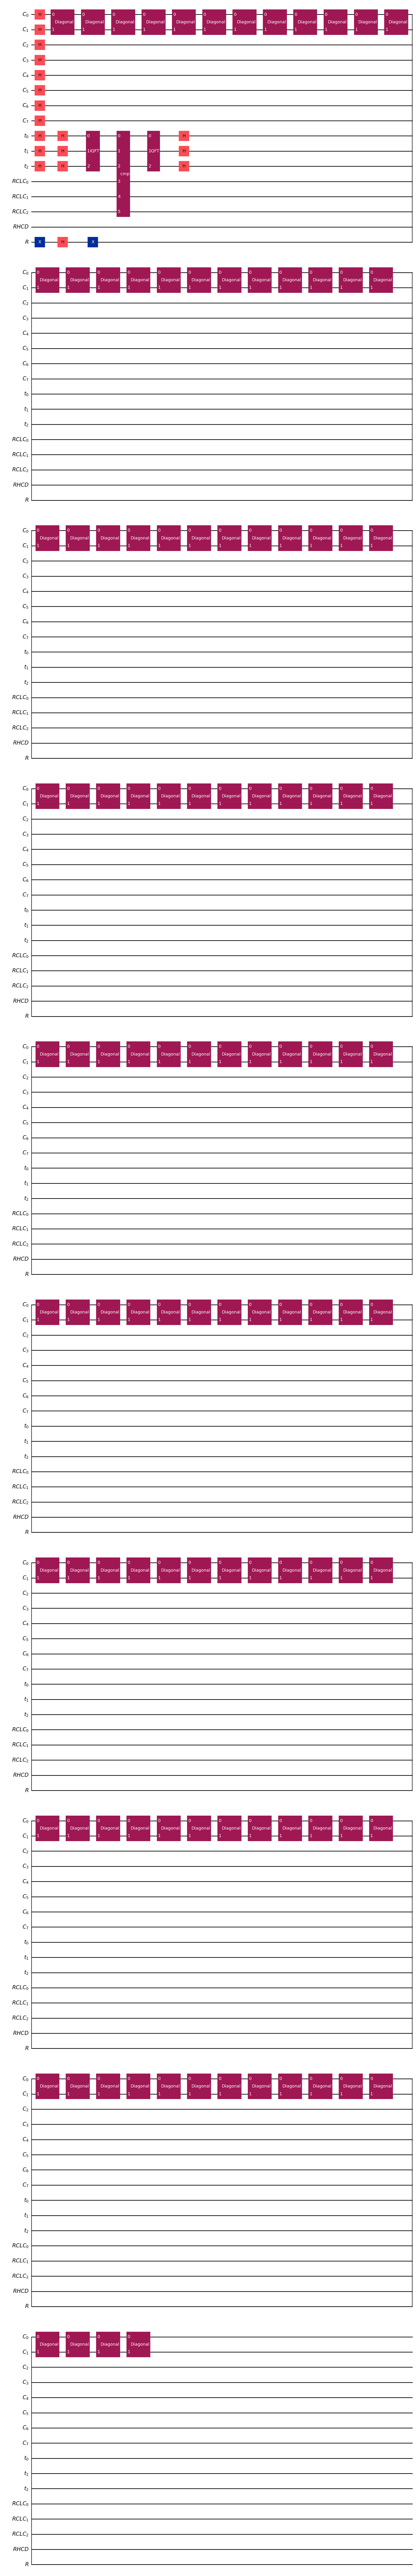

In [5]:
qr_C = QuantumRegister(m*N, 'C')
qr_t = QuantumRegister(t, 't')
qr_RCLC = QuantumRegister(t, 'RCLC')
qr_RHCD = QuantumRegister(1, 'RHCD')
qr_R = QuantumRegister(1, 'R')
registers = {"C":qr_C, "t":qr_t, "R":qr_R, "RCLC":qr_RCLC, "RHCD":qr_RHCD}

TSPcircuit = QuantumCircuit(qr_C, qr_t, qr_RCLC, qr_RHCD, qr_R)

TSPcircuit.x(qr_R)
TSPcircuit.h(qr_R)

for qubit in range(m*N):
    TSPcircuit.h(qr_C[qubit])

for qubit in range(t):
    TSPcircuit.h(qr_t[qubit])

TSPcircuit.x(qr_R)

# Display the circuit
TSPcircuit = apply_clc(TSPcircuit, registers, constants)
TSPcircuit.draw(output='mpl')